<a href="https://colab.research.google.com/github/jfvandem/dev_test_days/blob/master/intro_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dev test days 2019 - Meylan

basé sur https://www.kaggle.com/c/ashrae-energy-prediction/data

https://www.tensorflow.org/tutorials/keras/regression
https://www.tensorflow.org/tutorials/structured_data/time_series
https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series


# Clone github

In [154]:
!rm -rf dev_test_days
!git clone https://github.com/jfvandem/dev_test_days

Cloning into 'dev_test_days'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 100 (delta 9), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (100/100), 130.18 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Import

In [0]:
import gc
import glob
import io
import itertools
import joblib
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import re
import requests
import seaborn as sns
import tensorflow as tf
import time
import warnings
import zipfile

from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from math import sqrt
from matplotlib.collections import PatchCollection
from nltk.tokenize import word_tokenize
from os import path

from scipy import stats
from scipy.stats import skew

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")

In [157]:
print(tf.__version__)

2.0.0


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Chargement des données

In [159]:
!ls dev_test_days

dataset  intro_deep_learning.ipynb  README.md


In [0]:
data_dir='dev_test_days/dataset/'

In [161]:
df = pd.read_pickle(data_dir+'train_full_df.pkl.zip',compression='zip')
df.shape
df.head()

(6634879, 23)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
6,6,0,2016-01-01,0.0,0,4,27926,1981,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
7,7,0,2016-01-01,0.0,0,0,121074,1989,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
9,9,0,2016-01-01,0.0,0,6,27000,2010,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1


In [162]:
le=joblib.load(data_dir+'label_encoder.pkl')
le.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage'], dtype=object)

In [0]:
df['primary_use_label']=le.inverse_transform(df['primary_use'])

In [164]:
len(df.columns)
df.columns

24

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'primary_use_label'],
      dtype='object')

#Echantillonnage
Nous sélectionnons les batiments pour que l'apprentissage du modèle soit réalisé dans un temps raisonnable. Nous conservons uniquement les mesures réalisées sur le compteur d'électricité

In [165]:
df.shape
sample_building_list=[0,1,2,3,4]
df=df[df['meter']==0][df['building_id'].isin(sample_building_list)]
df.shape

(6634879, 24)

(17568, 24)

In [166]:
df['meter'].value_counts()

0    17568
Name: meter, dtype: int64

In [167]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2016-01-01 00:00:00
2016-12-31 23:00:00


In [168]:
print('fréquence des mesures : {}'.format(df.groupby('timestamp')['meter_reading'].mean().index.inferred_freq))

fréquence des mesures : H


# Description des colonnes


* air_temperature : température de l'air (degré Celsius)
* building_id : foreign key pour les données sur les immeubles (building_metadata)
* cloud_coverage : couverture nuageuse (oktas)
* dew température : température de rosée (degré Celsius)
* floor_count : nombre d'étages dans l'immeuble
* meter : code du type de compteur {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Tous les immeubles n'ont pas tous les types de compteur
* meter_reading : Consommation d'énergie en kWh (avec erreurs de mesure possibles) (la "**target**")
* precip_depth_1_hr : hauteur de précipitation en 1h (millimètre)
* primary_use : indicateur de l'activité des occupants dans l'immeuble selon la définition EnergyStar
* sea_level_pressure : pression au niveau de la mer (Millibar/hectopascals)
* site_id : foreign key pour les données météo
* square_feet : surface au plancher de l'immeuble (pied carré)
* timestamp : date à laquelle la mesure a été prise. Le timestamp a été "éclaté" en plusieurs champs (heure, jour, année, jour dans la semaine...)
* wind_direction : direction du vent (0 à 360 degré)
* wind_speed : vitesse du vent (m/s)
* year_built : année de construction de l'immeuble



In [169]:
# Valeurs manquantes (substitution réalisée dans le preprocessing, -1 ou moyenne)
df.isna().sum()

building_id            0
meter                  0
timestamp              0
meter_reading          0
site_id                0
primary_use            0
square_feet            0
year_built             0
floor_count            0
air_temperature        0
cloud_coverage         0
dew_temperature        0
precip_depth_1_hr      0
sea_level_pressure     0
wind_direction         0
wind_speed             0
month_datetime         0
weekofyear_datetime    0
dayofyear_datetime     0
hour_datetime          0
day_week               0
day_month_datetime     0
week_month_datetime    0
primary_use_label      0
dtype: int64

#Data Visualisation

In [0]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df.set_index('timestamp')['meter_reading']).set_title('consommation d\'électricité')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

# Features

In [0]:
feature_cols=['primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'month_datetime',
 'weekofyear_datetime',
 'dayofyear_datetime',
 'hour_datetime',
 'day_week',
 'day_month_datetime',
 'week_month_datetime']
target_col='meter_reading'

In [0]:
X=df[feature_cols]
y=df[target_col]

#Normalisation des données

cf. https://jovianlin.io/why-is-normalization-important-in-neural-networks/

In [106]:
X.describe()

,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
count,8784.0,8784.000000,8784.000000,8.784000e+03,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,0.0,0.956765,0.258502,-1.287359e-04,0.002882,0.000165,0.002108,0.000178,0.129714,0.000714,0.000435,0.000838,0.003430,0.023618,0.001480,0.000387,0.002028,0.000348
std,0.0,0.000893,0.000241,1.201347e-07,0.000780,0.000330,0.000830,0.001667,0.012846,0.000611,0.000277,0.000444,0.001943,0.013593,0.000891,0.000257,0.001134,0.000164
min,0.0,0.955789,0.258238,-1.298952e-04,0.000129,-0.000130,-0.001159,-0.000130,-0.000130,0.000000,0.000000,0.000129,0.000129,0.000129,0.000000,0.000000,0.000129,0.000129
25%,0.0,0.956492,0.258428,-1.287624e-04,0.002331,-0.000129,0.001672,0.000000,0.130656,0.000129,0.000270,0.000515,0.001803,0.011847,0.000741,0.000129,0.001030,0.000257
50%,0.0,0.956763,0.258501,-1.287356e-04,0.002961,0.000000,0.002316,0.000000,0.130963,0.000643,0.000399,0.000901,0.003476,0.023623,0.001486,0.000386,0.002059,0.000386
75%,0.0,0.956962,0.258555,-1.286991e-04,0.003348,0.000515,0.002831,0.000000,0.131310,0.001159,0.000592,0.001287,0.005148,0.035391,0.002235,0.000643,0.002962,0.000515
max,0.0,0.965381,0.260829,-1.286045e-04,0.004634,0.001168,0.003245,0.044126,0.132610,0.001948,0.001983,0.001557,0.006884,0.047228,0.002988,0.000779,0.004025,0.000649


In [0]:
normalizer=preprocessing.Normalizer()

X_normalized=normalizer.fit_transform(X)

In [109]:
pd.DataFrame(X_normalized).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,8784.0,8784.000000,8784.000000,8.784000e+03,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,0.0,0.956765,0.258502,-1.287359e-04,0.002882,0.000165,0.002108,0.000178,0.129714,0.000714,0.000435,0.000838,0.003430,0.023618,0.001480,0.000387,0.002028,0.000348
std,0.0,0.000893,0.000241,1.201347e-07,0.000780,0.000330,0.000830,0.001667,0.012846,0.000611,0.000277,0.000444,0.001943,0.013593,0.000891,0.000257,0.001134,0.000164
min,0.0,0.955789,0.258238,-1.298952e-04,0.000129,-0.000130,-0.001159,-0.000130,-0.000130,0.000000,0.000000,0.000129,0.000129,0.000129,0.000000,0.000000,0.000129,0.000129
25%,0.0,0.956492,0.258428,-1.287624e-04,0.002331,-0.000129,0.001672,0.000000,0.130656,0.000129,0.000270,0.000515,0.001803,0.011847,0.000741,0.000129,0.001030,0.000257
50%,0.0,0.956763,0.258501,-1.287356e-04,0.002961,0.000000,0.002316,0.000000,0.130963,0.000643,0.000399,0.000901,0.003476,0.023623,0.001486,0.000386,0.002059,0.000386
75%,0.0,0.956962,0.258555,-1.286991e-04,0.003348,0.000515,0.002831,0.000000,0.131310,0.001159,0.000592,0.001287,0.005148,0.035391,0.002235,0.000643,0.002962,0.000515
max,0.0,0.965381,0.260829,-1.286045e-04,0.004634,0.001168,0.003245,0.044126,0.132610,0.001948,0.001983,0.001557,0.006884,0.047228,0.002988,0.000779,0.004025,0.000649


A noter, la normalisation devra être appliquée sur toute nouvelle donnée soumise au modèle par la suite

# Découpage train / test

In [84]:
train_df=df[df['timestamp'].dt.month<11]
test_df=df[df['timestamp'].dt.month>=11]

X_train=train_df[feature_cols]
y_train=train_df[target_col]
y_train=np.asarray(y_train)

X_test=test_df[feature_cols]
y_test=test_df[target_col]
y_test=np.asarray(y_test)

print(train_df.shape)
print(test_df.shape)

(7320, 24)
(1464, 24)


#Apprentissage

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1280      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


In [89]:
BATCH_SIZE=64
EPOCHS = 600

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


history = model.fit(
  X_train_normalized, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [90]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,713.279627,14.119372,713.279663,5604.054421,71.341583,5604.054688,995
996,710.200653,14.175159,710.200623,4838.635422,65.759262,4838.635742,996
997,717.854507,14.219823,717.854492,4246.338435,61.101894,4246.338379,997
998,702.119681,14.146635,702.119629,4869.937569,65.999176,4869.937012,998
999,691.011434,14.059303,691.011353,4714.303497,64.809692,4714.303223,999


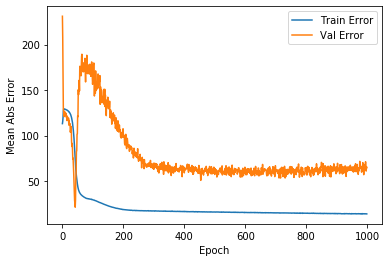

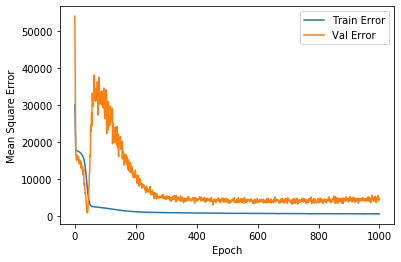

In [91]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [92]:
loss, mae, mse = model.evaluate(X_test_normalized, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))


1464/1 - 0s - loss: 16276.4926 - mae: 136.0590 - mse: 20496.3477
Testing set Mean Abs Error: 136.06


In [0]:
y_pred = model.predict(X_test_normalized).flatten()

In [0]:
test_df['pred']=y_pred

In [95]:
test_df['building_id'].drop_duplicates()

16800257    0
Name: building_id, dtype: uint16

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '0')

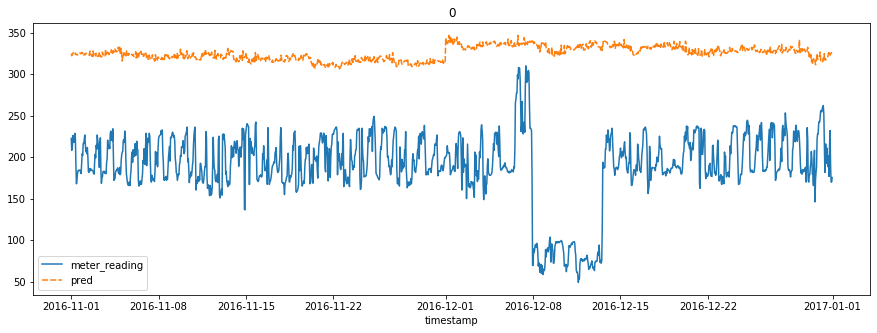

In [96]:
data=test_df.set_index('timestamp')

meter_list=test_df['meter'].unique().tolist()

for m in meter_list:
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data[data['meter']==m][[target_col,'pred']]).set_title(m)

